Epoch 1/30
34/34 [==============================] - 9s 67ms/step - loss: 0.0042 - val_loss: 0.0119
Epoch 2/30
34/34 [==============================] - 1s 24ms/step - loss: 0.0010 - val_loss: 0.0100
Epoch 3/30
34/34 [==============================] - 1s 23ms/step - loss: 9.6354e-04 - val_loss: 0.0121
Epoch 4/30
34/34 [==============================] - 1s 24ms/step - loss: 9.2451e-04 - val_loss: 0.0107
Epoch 5/30
34/34 [==============================] - 1s 24ms/step - loss: 8.3465e-04 - val_loss: 0.0079
Epoch 6/30
34/34 [==============================] - 1s 28ms/step - loss: 9.1346e-04 - val_loss: 0.0074
Epoch 7/30
34/34 [==============================] - 1s 24ms/step - loss: 8.4161e-04 - val_loss: 0.0070
Epoch 8/30
34/34 [==============================] - 1s 23ms/step - loss: 8.5326e-04 - val_loss: 0.0101
Epoch 9/30
34/34 [==============================] - 1s 23ms/step - loss: 7.4571e-04 - val_loss: 0.0070
Epoch 10/30
34/34 [==============================] - 1s 23ms/step - loss: 7.8548e

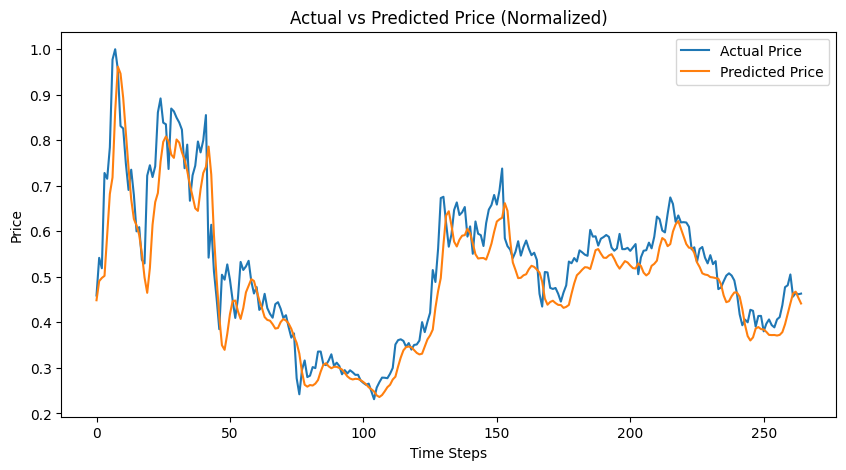

1/1 [==============================] - 0s 42ms/step

Predicted Next Day Closing Price:
Normalized: 0.43221
Original Scale: 0.86989
1/1 [==============================] - 0s 50ms/step

External Input Prediction:
Normalized: 0.22094
Original Scale: 0.51091

External Prediction Accuracy (vs Actual = 0.58):
MSE: 0.00477
MAE: 0.06909
R² Score: nan

Model and scaler saved successfully.


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import os

# Ensure model directory exists
os.makedirs("model", exist_ok=True)

# Step 1: Load dataset
df = pd.read_csv(r"12 (2) (Data).csv")

# Step 2: Date conversion and sorting
df['date'] = pd.to_datetime(df['date'], format='%m-%d-%Y')
df = df.sort_values('date')

# Step 3: Drop unwanted columns
df.drop(columns=['symbol', 'unix'], inplace=True)

# Step 4: Normalize using MinMaxScaler
cols_to_scale = ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Step 5: Set 'date' as index
df.set_index('date', inplace=True)

# Step 6: Create sequences
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[cols_to_scale].values[i-sequence_length:i])
    y.append(df['close'].values[i])

X, y = np.array(X), np.array(y)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Step 9: Compile & train
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 10: Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Evaluation:")
print(f"MSE: {mse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R² Score: {r2:.5f}")

# Step 11: Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Price (Normalized)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 12: Predict Next Day Price from Last 10 Days
def predict_next_day(model, df_scaled, scaler, sequence_length=10):
    last_sequence = df_scaled[cols_to_scale].tail(sequence_length).values
    last_sequence = np.expand_dims(last_sequence, axis=0)
    pred_norm = model.predict(last_sequence)[0][0]

    # Denormalize
    close_min = scaler.data_min_[3]
    close_max = scaler.data_max_[3]
    pred_orig = pred_norm * (close_max - close_min) + close_min
    return pred_norm, pred_orig

pred_norm, pred_orig = predict_next_day(model, df, scaler)
print(f"\nPredicted Next Day Closing Price:")
print(f"Normalized: {pred_norm:.5f}")
print(f"Original Scale: {pred_orig:.5f}")

# Step 13: Predict on External Input
def predict_from_external_input(model, input_df, scaler, sequence_length=10):
    required_cols = ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT']
    assert list(input_df.columns) == required_cols, f"Input columns must be {required_cols}"
    if len(input_df) != sequence_length:
        raise ValueError(f"Input must contain exactly {sequence_length} rows.")
    
    input_scaled = scaler.transform(input_df)
    input_seq = np.expand_dims(input_scaled, axis=0)

    pred_norm = model.predict(input_seq)[0][0]
    close_min = scaler.data_min_[3]
    close_max = scaler.data_max_[3]
    pred_orig = pred_norm * (close_max - close_min) + close_min

    return pred_norm, pred_orig

# Step 14: Simulate new external data (replace with actual real-time input)
external_data = pd.DataFrame({
    'open': [0.5]*10,
    'high': [0.6]*10,
    'low': [0.4]*10,
    'close': [0.55]*10,
    'Volume XRP': [0.8]*10,
    'Volume USDT': [0.9]*10
})

ext_pred_norm, ext_pred_orig = predict_from_external_input(model, external_data, scaler)
print(f"\nExternal Input Prediction:")
print(f"Normalized: {ext_pred_norm:.5f}")
print(f"Original Scale: {ext_pred_orig:.5f}")

# Step 15: Accuracy against actual value (optional)
actual_next_day_price = 0.58  # Replace with actual price if available
mse_ext = mean_squared_error([actual_next_day_price], [ext_pred_orig])
mae_ext = mean_absolute_error([actual_next_day_price], [ext_pred_orig])
r2_ext = r2_score([actual_next_day_price], [ext_pred_orig])

print(f"\nExternal Prediction Accuracy (vs Actual = {actual_next_day_price}):")
print(f"MSE: {mse_ext:.5f}")
print(f"MAE: {mae_ext:.5f}")
print(f"R² Score: {r2_ext:.5f}")

# Step 16: Save model and scaler
model.save("model/lstm_model.h5")
joblib.dump(scaler, "model/scaler.pkl")
print("\nModel and scaler saved successfully.")


Epoch 1/30
34/34 [==============================] - 10s 69ms/step - loss: 0.0034 - val_loss: 0.0100
Epoch 2/30
34/34 [==============================] - 1s 27ms/step - loss: 0.0011 - val_loss: 0.0089
Epoch 3/30
34/34 [==============================] - 1s 24ms/step - loss: 0.0012 - val_loss: 0.0100
Epoch 4/30
34/34 [==============================] - 1s 24ms/step - loss: 9.1186e-04 - val_loss: 0.0099
Epoch 5/30
34/34 [==============================] - 1s 24ms/step - loss: 9.2690e-04 - val_loss: 0.0069
Epoch 6/30
34/34 [==============================] - 1s 24ms/step - loss: 8.1343e-04 - val_loss: 0.0073
Epoch 7/30
34/34 [==============================] - 1s 24ms/step - loss: 8.1327e-04 - val_loss: 0.0095
Epoch 8/30
34/34 [==============================] - 1s 24ms/step - loss: 7.6190e-04 - val_loss: 0.0060
Epoch 9/30
34/34 [==============================] - 1s 24ms/step - loss: 7.7763e-04 - val_loss: 0.0062
Epoch 10/30
34/34 [==============================] - 1s 24ms/step - loss: 7.8872e-04

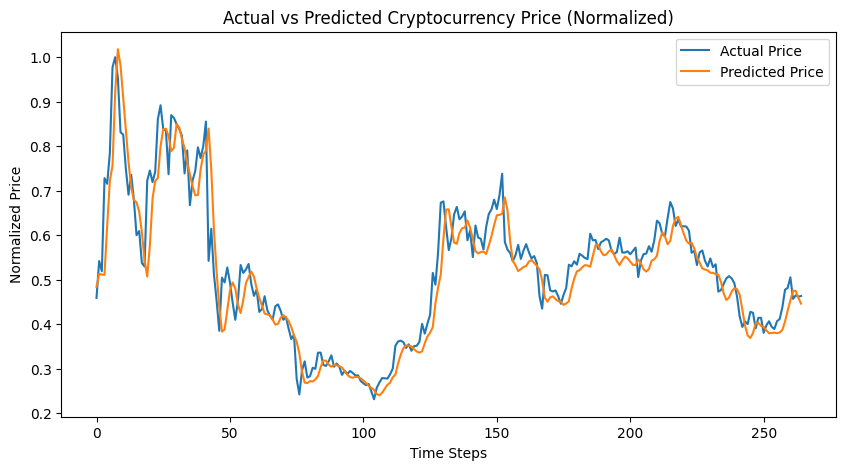

1/1 [==============================] - 0s 49ms/step

Predicted Closing Price for Next Day (Normalized): 0.43812
Predicted Closing Price for Next Day (Original Scale): 0.87993
1/1 [==============================] - 0s 37ms/step
External Input - Predicted Closing Price (Normalized): 0.21888
External Input - Predicted Closing Price (Original Scale): 0.50741
External Prediction MSE: 0.00527
External Prediction MAE: 0.07259
External Prediction R² Score: nan


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load the CSV file
df = pd.read_csv(r"12 (2) (Data).csv")

# Step 2: Convert 'date' column to datetime and sort
df['date'] = pd.to_datetime(df['date'], format='%m-%d-%Y')
df = df.sort_values('date')

# Step 3: Drop unnecessary columns
df = df.drop(columns=['symbol', 'unix'])

# Step 4: Normalize price and volume columns
scaler = MinMaxScaler()
cols_to_scale = ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Step 5: Set date as index
df.set_index('date', inplace=True)

# Step 6: Define the sequence length
sequence_length = 10

# Step 7: Prepare sequences and target
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[cols_to_scale].values[i-sequence_length:i])
    y.append(df['close'].values[i])

X = np.array(X)
y = np.array(y)

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 9: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Step 10: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 11: Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Step 12: Predict on test data
y_pred = model.predict(X_test)

# Step 13: Evaluation metrics on test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Evaluation:")
print(f"MSE: {mse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R² Score: {r2:.5f}")

# Step 14: Visualize predicted vs actual
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Cryptocurrency Price (Normalized)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

# Step 15: Predict Next Day Price Using Last 10 Days of Data
def predict_next_day(model, df_scaled, scaler, sequence_length=10):
    last_sequence = df_scaled[cols_to_scale].tail(sequence_length).values
    last_sequence = np.expand_dims(last_sequence, axis=0)
    predicted_price_norm = model.predict(last_sequence)[0][0]

    # Denormalize
    close_min = scaler.data_min_[3]
    close_max = scaler.data_max_[3]
    predicted_price_original = predicted_price_norm * (close_max - close_min) + close_min

    return predicted_price_norm, predicted_price_original

# Step 16: Predict Next Day
predicted_close_norm, predicted_close_original = predict_next_day(model, df, scaler, sequence_length)

print(f"\nPredicted Closing Price for Next Day (Normalized): {predicted_close_norm:.5f}")
print(f"Predicted Closing Price for Next Day (Original Scale): {predicted_close_original:.5f}")

# Step 17: Function to Predict on Custom User Input Data
def predict_user_input(model, user_input_df, scaler, sequence_length=10):
    if user_input_df.shape[0] != sequence_length:
        raise ValueError(f"User input must have {sequence_length} rows.")

    # Normalize
    user_scaled = scaler.transform(user_input_df[cols_to_scale])
    sequence = np.expand_dims(user_scaled, axis=0)
    
    # Predict
    pred_norm = model.predict(sequence)[0][0]
    close_min = scaler.data_min_[3]
    close_max = scaler.data_max_[3]
    pred_original = pred_norm * (close_max - close_min) + close_min

    return pred_norm, pred_original

# Example for User: Provide a DataFrame with last 10 rows manually
# Sample usage:
"""
user_input_data = df[cols_to_scale].tail(10).copy()  # or any other 10-row valid input DataFrame
norm, orig = predict_user_input(model, user_input_data, scaler)
print(f"User Input Prediction (Normalized): {norm:.5f}")
print(f"User Input Prediction (Original Scale): {orig:.5f}")
"""
def predict_from_external_input(model, input_data_df, scaler, sequence_length=10):
    """
    Accepts raw external data (10 rows with open, high, low, close, Volume XRP, Volume USDT),
    scales it, reshapes it, predicts next closing price, and returns original-scale prediction.
    """
    # Ensure input has correct columns
    required_cols = ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT']
    assert list(input_data_df.columns) == required_cols, "Input DataFrame must have the correct columns."

    # Normalize using the same scaler
    input_scaled = scaler.transform(input_data_df)

    # Prepare sequence for prediction
    input_seq = np.array([input_scaled[-sequence_length:]])  # Shape: (1, 10, 6)

    # Predict
    predicted_norm = model.predict(input_seq)[0][0]

    # Denormalize the predicted 'close' price
    close_min = scaler.data_min_[3]
    close_max = scaler.data_max_[3]
    predicted_original = predicted_norm * (close_max - close_min) + close_min

    return predicted_norm, predicted_original
# Example: Simulate new external data (replace with real values)
new_external_data = pd.DataFrame({
    'open': [0.5]*10,
    'high': [0.6]*10,
    'low': [0.4]*10,
    'close': [0.55]*10,
    'Volume XRP': [0.8]*10,
    'Volume USDT': [0.9]*10
})

# Predict from user input
norm_pred, orig_pred = predict_from_external_input(model, new_external_data, scaler)

print(f"External Input - Predicted Closing Price (Normalized): {norm_pred:.5f}")
print(f"External Input - Predicted Closing Price (Original Scale): {orig_pred:.5f}")
# Let's say this is the actual closing price (true label from next day)
actual_close_price = 0.58  # You would get this from real data

# Calculate accuracy
mse = mean_squared_error([actual_close_price], [orig_pred])
mae = mean_absolute_error([actual_close_price], [orig_pred])
r2 = r2_score([actual_close_price], [orig_pred])

print(f"External Prediction MSE: {mse:.5f}")
print(f"External Prediction MAE: {mae:.5f}")
print(f"External Prediction R² Score: {r2:.5f}")
# Save LSTM model
model.save("model/lstm_model.h5")

# Save scaler
import joblib
joblib.dump(scaler, "model/scaler.pkl")
